# Downloading the data

In [1]:
#Import packages 

import yfinance as yf # Finance API that updates data in real-time
msft = yf.Ticker("MSFT") 
msft_hist = msft.history(period="max") 
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
# Display microsoft stock price history so we can look at the structure of the data

msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0


As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

- Open - the price the stock opened at.
- High - the highest price during the day
- Low - the lowest price during the day
- Close - the closing price on the trading day
- Volume - how many shares were traded

**Note:** There is no trading on weekends and holidays which is why some dates are missing

### *Visualize Microsoft Stock Prices*

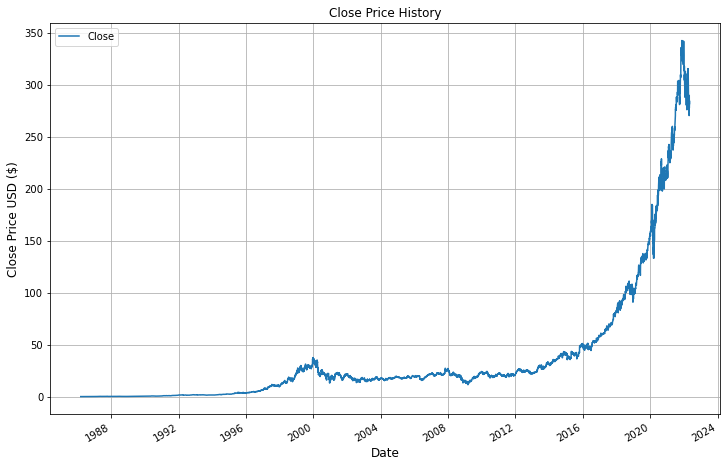

In [3]:
# Structure the chart

msft_hist.plot.line(y="Close", figsize=(12,8), use_index=True)
plt.title("Close Price History")
plt.xlabel("Date", fontsize = "12")
plt.ylabel("Close Price USD ($)", fontsize = "12")
plt.grid()

# Preparing the data
First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be **1** and if it went down, the target will be **0**.

In [4]:
# Ensure we know the actual closing price

data = msft_hist[["Close"]]
data = data.rename(columns = {"Close":"Actual_Close"})

# Setup our target.  This identifies if the price went up or down

data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [5]:
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13,0.061252,NaN
1986-03-14,0.063439,1.0
1986-03-17,0.064533,1.0
1986-03-18,0.062892,0.0
1986-03-19,0.061799,0.0


### Shift data forward by a day
Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

In [6]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.

msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

### Create our training data

In [7]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063439,1.0,0.061252,1.031789e+09,0.055783,0.063987,0.055783
1986-03-17,0.064533,1.0,0.063439,3.081600e+08,0.061252,0.064533,0.061252
1986-03-18,0.062892,0.0,0.064533,1.331712e+08,0.063439,0.065080,0.063439
1986-03-19,0.061799,0.0,0.062892,6.776640e+07,0.064533,0.065080,0.062345
1986-03-20,0.060158,0.0,0.061799,4.789440e+07,0.062892,0.063439,0.061252


# Creating a classification machine learning model
We are going to use a classification model because our target is binary meaning that it will either be a **1** or **0** in respect to whether the stock price went up or down from the previous day. 

### Install machine learning package "scikit-learn"
This package has most common machine learning algorithms already implemented. 

In [8]:
# Install scikit-learn

!pip install scikit-learn

### Use Random Forest Classifier to generate our predictions
This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

- The n_estimators=100 indicates how many individual decision trees we want to train. Thus, we will train 100 decision trees, and average their results. 
- Random forest and decision trees can easily overfit the data so we will use min_samples_split to prevent decision trees from fitting itself as tightly to the data. 
- The less tightly you're fitting, the better you can generalize to future data. 
- Use random_state to ensure that our results remain constant

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classification model. 
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
#taking the whole dataset except the last 100 rows
train = data.iloc[:-100]

#Predict the last 100 rows 
test = data.iloc[-100:]

# Fit the model on our training dataset with our predictors. 
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

### Use precision to measure error
We want to maximize our **true positives** - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is **true positives / (false positives + true positives)**. This will ensure that we minimize how much money we lose with **false positives** (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of **false negatives** - days when we predict that the price will go down, but it actually goes up. This is okay since we'd rather minimize our potential losses than maximize our potential gains.


### Precision Score

In [10]:
# scikit-learn has a function called "precision score" 
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4835164835164835

Our model's predictions are not very accurate. We can take a deeper look at the individual predictions and the actuals, and see where we're off.

### Lets take a deeper look

In [11]:
# Target - actual values 
# Predictions - what the algorithm predicted 
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined

,Target,Predictions
Date,,
2021-12-09,0.0,1.0
2021-12-10,1.0,1.0
2021-12-13,0.0,1.0
2021-12-14,0.0,0.0
2021-12-15,1.0,1.0
...,...,...
2022-04-27,1.0,1.0
2022-04-28,1.0,1.0
2022-04-29,0.0,1.0


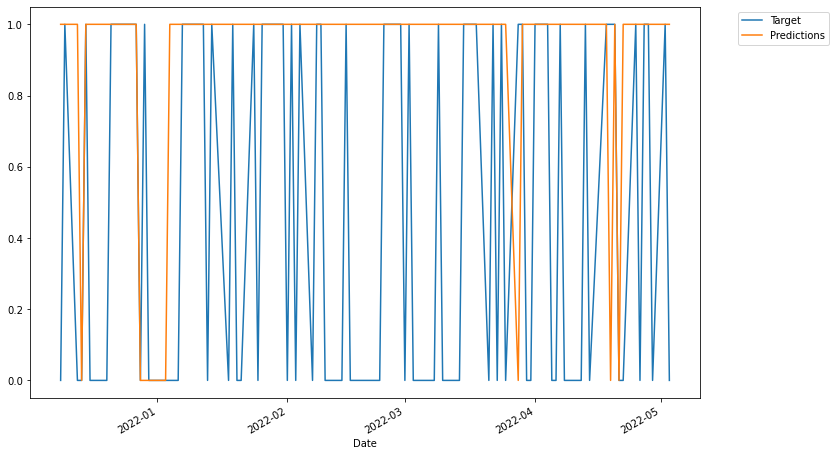

In [12]:
combined.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc = "upper left")

# Backtesting
Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have had atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions. 

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will: 
- Split the training and test data
- Train a model 
- Make predictions on the test data using **predict_proba** - this is because we want to really optimize for true positives. By default, the threshold for splitting is 0/1 or .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [13]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

predictions = backtest(data, model, predictors)
predictions["Predictions"].value_counts()

0.0    7373
1.0     736
Name: Predictions, dtype: int64

In [14]:
precision_score(predictions["Target"], predictions["Predictions"])

0.49184782608695654

As you can see, our model made fewer trades, but it did slightly improve its accuracy. This is because we used .6 as a threshold for trading.

Although we are trading less, the hope is to predict with accuracy and minimize the potential for loss.  

# Improving accuracy 
The model still isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we must get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [15]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [16]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

#this helps the algorithm understand trends 
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [17]:
# Add our new predictors to our backtest function 
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", 
                                "annual_weekly_mean", "annual_quarterly_mean", 
                                "open_close_ratio", "high_close_ratio", "low_close_ratio", 
                                "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

### Precision Score

In [18]:
predictions["Predictions"].value_counts()

0.0    7532
1.0     212
Name: Predictions, dtype: int64

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6037735849056604

In [20]:
predictions

,Target,Predictions
Date,,
1991-08-07,1.0,0.0
1991-08-08,1.0,0.0
1991-08-09,1.0,0.0
1991-08-12,1.0,0.0
1991-08-13,0.0,0.0
...,...,...
2022-04-27,1.0,1.0
2022-04-28,1.0,0.0
2022-04-29,0.0,0.0


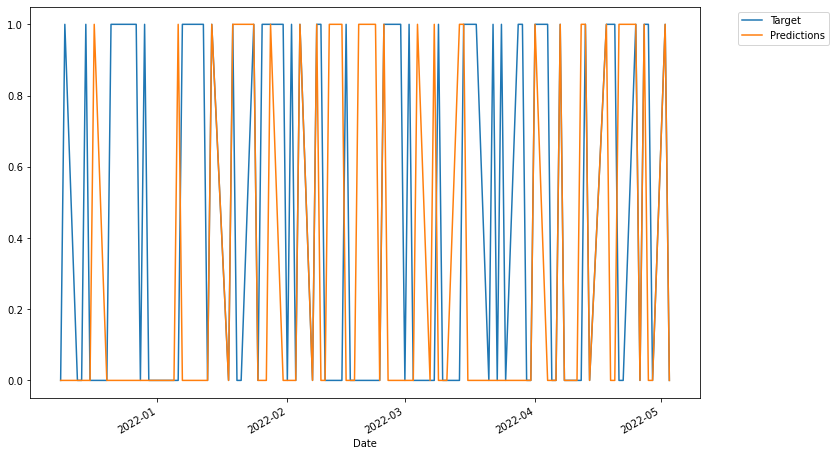

In [21]:
predictions.iloc[-100:].plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc = "upper left")

# Next Steps
We've come far in this project! We've downloaded and cleaned data, and setup a backtesting engine. We now have an algorithm that we can add more predictors to and continue to improve the accuracy of.

There are a lot of next steps we could take to improve our predictions:

### Improve the technique 
- Calculate how much money you'd make if you traded with this algorithm

### Improve the algorithm
- Run with a reduced step size! This will take longer, but increase accuracy
- Try discarding older data (only keeping data in a certain window)
- Try a different machine learning algorithm
- Tweak random forest parameters, or the prediction threshold

### Add in more predictors
- Account for activity post-close and pre-open
    Early trading
    - Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
- Economic indicators
    - Interest rates
    - Other important economic news
- Key dates
    - Dividends
    - External factors like elections
- Company milestones
    - Earnings calls
    - Analyst ratings
    - Major announcements
- Prices of related stocks
    - Other companies in the same sector
    - Key partners, customers, etc.